In [1]:
# Import Modules
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
import numpy as np 

In [65]:
# Import Data
data = pd.read_excel('/Users/talhajamal/Desktop/Code/Regression_Analysis/data/data_coursework_Q1.xls')

# Drop certain columns and rows
data = data.iloc[3:, 0:8]
data.drop(['Unnamed: 0', 'Unnamed: 5'], axis=1, inplace=True)
data.columns = ['Year', 'Month', 'Date', '1M T-bill', 'SP500', 'IBM']
data = data[['Date', 'Year', 'Month', '1M T-bill', 'SP500', 'IBM']]
data.dropna(inplace=True)
data.reset_index(inplace=True)

# Generate Features for Simple CAPM Regression
data['Rf'] = data['1M T-bill'] / 100
data['Ri'] = (data['IBM'] / data['IBM'].shift(1)) - 1
data['Rm'] = (data['SP500'] / data['SP500'].shift(1)) - 1
data['Excess Return'] = data['Ri'] - data['Rf']
data['Market Excess Return'] = data['Rm'] - data['Rf']
data.dropna(inplace=True)
data.head()

,index,Date,Year,Month,1M T-bill,SP500,IBM,Rf,Ri,Rm,Excess Return,Market Excess Return
1,25,FEB 1962,1962,2,0.20,70.22,2.66,0.0020,-0.011152,0.016650,-0.013152,0.014650
2,26,MAR 1962,1962,3,0.20,70.29,2.64,0.0020,-0.007519,0.000997,-0.009519,-0.001003
3,27,APR 1962,1962,4,0.22,68.05,2.25,0.0022,-0.147727,-0.031868,-0.149927,-0.034068
4,28,MAY 1962,1962,5,0.24,62.99,1.95,0.0024,-0.133333,-0.074357,-0.135733,-0.076757
5,29,JUN 1962,1962,6,0.20,55.63,1.68,0.0020,-0.138462,-0.116844,-0.140462,-0.118844


In [66]:
# Do a 80-20 split of data for training and testing the CAPM Model
M1_train = data[ :277]
M1_test = data[ 277:]

M1_X_train = M1_train[['Market Excess Return']] # Train features must be 2D
M1_Y_train = M1_train[['Excess Return']] # Target feature must be 1D

M1_X_test = M1_test[['Market Excess Return']]
M1_Y_test = M1_test[['Excess Return']]

# Run Simple CAPM Model
model_1 = LinearRegression()
model_1.fit(M1_X_train, M1_Y_train)

# Generate Predictions
M1_Y_pred = model_1.predict(M1_X_test)

# Simple CAPM Results
# Coefficient and Intercept
print(f"Coefficient: {model_1.coef_[0]}")
print(f"Intercept: {model_1.intercept_}")

# Scoring the model (R^2 Score)
M1_r2_score = model_1.score(M1_X_test, M1_Y_test)
print(f"R^2 Score: {M1_r2_score}")

Coefficient: [0.87788167]
Intercept: [0.00496573]
R^2 Score: 0.28704873559643507


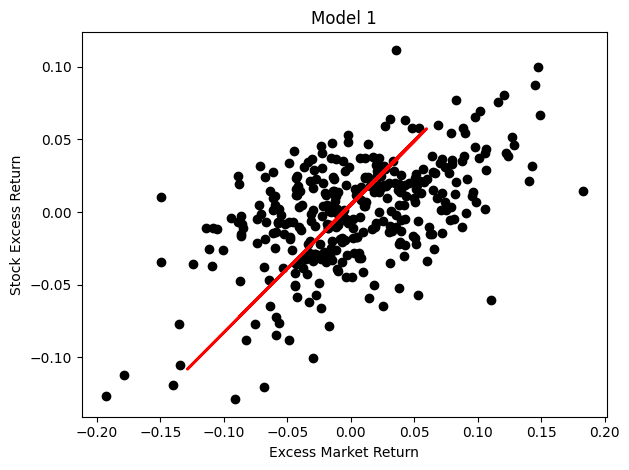

In [67]:
# Plotting the results
plt.scatter(data['Excess Return'], data['Market Excess Return'], color='black')
plt.plot(M1_X_test, M1_Y_pred, color='red', linewidth=2)
plt.xlabel('Excess Market Return')
plt.ylabel('Stock Excess Return')
plt.title('Model 1')
plt.tight_layout()
plt.show()

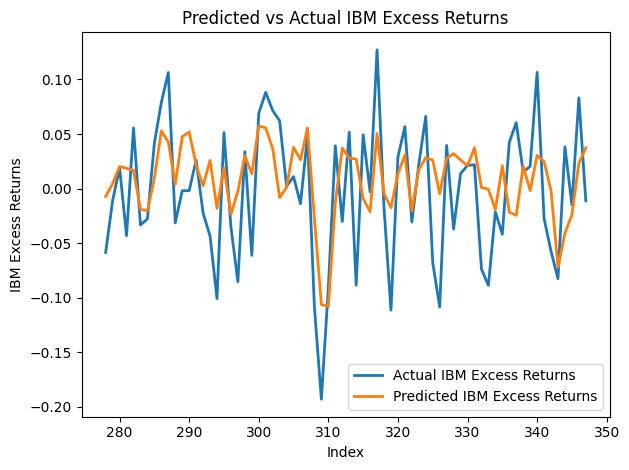

In [68]:
# Plotting Prediction and Actual Values
plt.plot(M1_Y_test.index, M1_Y_test, label='Actual IBM Excess Returns', linewidth=2)
plt.plot(M1_Y_test.index, M1_Y_pred, label='Predicted IBM Excess Returns', linewidth=2)
plt.xlabel('Index')
plt.ylabel('IBM Excess Returns')
plt.title('Predicted vs Actual IBM Excess Returns')
plt.legend()
plt.tight_layout()
plt.show()

In [69]:
# Features for StatsModels OLS
M1_X_train_series = M1_train[['Market Excess Return']]
M1_X_train_series = sm.add_constant(M1_X_train_series) # Add Constant / Intercept
M1_Y_train_series = M1_train[['Excess Return']]

# SM does not use objects, it needs Numeric (Float/Int) for Computation
M1_X_train_series = M1_X_train_series.astype(float) 
M1_Y_train_series = M1_Y_train_series.astype(float)

# Run Model 1 with OLS
SM_Model_1 = sm.OLS(M1_Y_train_series, M1_X_train_series).fit()

In [70]:
# Multiple Factor Model
# Create D -> Indicator Variable for Positive Market Excess Returns
data['D'] = (data['Market Excess Return'] > 0).astype(int)

# Generate Features
data['Factor 1'] = data['D'] * data['Market Excess Return']
data['Factor 2'] = (1 - data['D']) * data['Market Excess Return']
data['Factor 3'] = (data['Market Excess Return'])**2

data.head()


,index,Date,Year,Month,1M T-bill,SP500,IBM,Rf,Ri,Rm,Excess Return,Market Excess Return,D,Factor 1,Factor 2,Factor 3
1,25,FEB 1962,1962,2,0.20,70.22,2.66,0.0020,-0.011152,0.016650,-0.013152,0.014650,1,0.01465,0.000000,0.000215
2,26,MAR 1962,1962,3,0.20,70.29,2.64,0.0020,-0.007519,0.000997,-0.009519,-0.001003,0,-0.00000,-0.001003,0.000001
3,27,APR 1962,1962,4,0.22,68.05,2.25,0.0022,-0.147727,-0.031868,-0.149927,-0.034068,0,-0.00000,-0.034068,0.001161
4,28,MAY 1962,1962,5,0.24,62.99,1.95,0.0024,-0.133333,-0.074357,-0.135733,-0.076757,0,-0.00000,-0.076757,0.005892
5,29,JUN 1962,1962,6,0.20,55.63,1.68,0.0020,-0.138462,-0.116844,-0.140462,-0.118844,0,-0.00000,-0.118844,0.014124


In [71]:
# Do a 80-20 split of data for training and testing the CAPM Model
M2_train = data[ :277]
M2_test = data[ 277:]

M2_X_train = M2_train[['Factor 1', 'Factor 2', 'Factor 3']] # Train features must be 2D
M2_Y_train = M2_train['Excess Return'] # Target feature must be 1D

M2_X_test = M2_test[['Factor 1', 'Factor 2', 'Factor 3']]
M2_Y_test = M2_test['Excess Return']

# Run Multiple Factor CAPM Model
model_2 = LinearRegression()
model_2.fit(M2_X_train, M2_Y_train)

# Predictions
M2_Y_pred = model_2.predict(M2_X_test)

# Coefficient and Intercept
print(f"Coefficients: {model_2.coef_}")
print(f"Intercept: {model_2.intercept_}")

# Scoring the model (R^2 Score)
M2_r2_score = model_2.score(M2_X_test, M2_Y_test)
print(f"R^2 Score: {M2_r2_score}")

Coefficients: [ 1.52149705  0.23942446 -4.95589876]
Intercept: -0.005941013991340763
R^2 Score: 0.30727175419123753


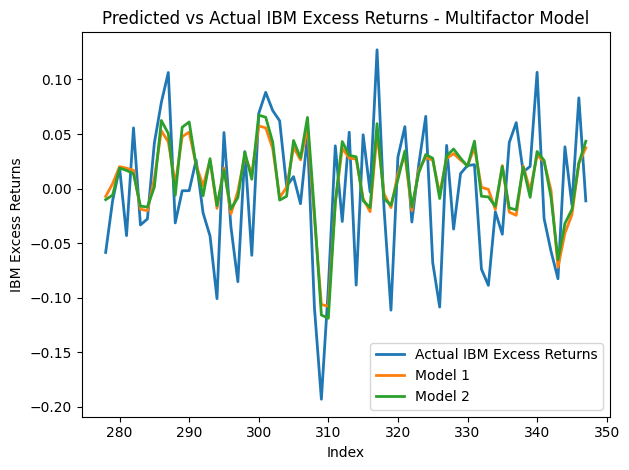

In [72]:
# Plotting Prediction and Actual Values
plt.plot(M2_Y_test.index, M2_Y_test, label='Actual IBM Excess Returns', linewidth=2)
plt.plot(M2_Y_test.index, M1_Y_pred, label='Model 1', linewidth=2)
plt.plot(M2_Y_test.index, M2_Y_pred, label='Model 2', linewidth=2)
plt.xlabel('Index')
plt.ylabel('IBM Excess Returns')
plt.title('Predicted vs Actual IBM Excess Returns - Multifactor Model')
plt.legend()
plt.tight_layout()
plt.show()

In [73]:
# Comparing R square of both models
print(f"R Square for Model 1: {M1_r2_score}")
print(f"R Square for Model 2: {M2_r2_score}")

R Square for Model 1: 0.28704873559643507
R Square for Model 2: 0.30727175419123753


In [74]:
# Model 2 via StatsModels
# Features for StatsModels OLS
M2_X_train_series = M2_train[['Factor 1', 'Factor 2', 'Factor 3']]
M2_X_train_series = sm.add_constant(M2_X_train_series) # Add Constant / Intercept
M2_Y_train_series = M2_train[['Excess Return']]

# SM does not use objects, it needs Numeric (Float/Int) for Computation
M2_X_train_series = M2_X_train_series.astype(float) 
M2_Y_train_series = M2_Y_train_series.astype(float)

# Run Model 2 with OLS
SM_Model_2 = sm.OLS(M2_Y_train_series, M2_X_train_series).fit()


In [76]:
# Model 1 with OLS
print(SM_Model_1.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess Return   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     108.2
Date:                Sat, 30 Dec 2023   Prob (F-statistic):           1.39e-21
Time:                        19:39:17   Log-Likelihood:                 436.01
No. Observations:                 277   AIC:                            -868.0
Df Residuals:                     275   BIC:                            -860.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0050 

In [75]:
# Model 2 with OLS
print(SM_Model_2.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess Return   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     37.69
Date:                Sat, 30 Dec 2023   Prob (F-statistic):           2.07e-20
Time:                        19:36:40   Log-Likelihood:                 438.06
No. Observations:                 277   AIC:                            -868.1
Df Residuals:                     273   BIC:                            -853.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0059      0.006     -0.950      0.3

#### Condition Number large for second model - fix multicollinearity here
